In [1]:
import requests
from io import BytesIO
import matplotlib.pyplot as plt
from torchvision import transforms as pth_transforms

import argparse
import os
import sys
import datetime
import time
import math
import json
from pathlib import Path

import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.distributed as dist
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision import models as torchvision_models

import utils
import vision_transformer as vits
from vision_transformer import DINOHead

In [2]:
patch_size = 8
out_dim = 65536
arch = "deit_small"
use_bn_in_head = False
norm_last_layer = True

In [3]:
student = vits.__dict__[arch](patch_size=patch_size, drop_path_rate=0.1)
student.head = DINOHead(student.embed_dim, out_dim, use_bn=use_bn_in_head, norm_last_layer=norm_last_layer)

In [4]:
checkpoint = torch.load("./pretrained_weights/dino_deitsmall8_pretrain_full_checkpoint.pth", map_location="cpu")

In [5]:
student_state_dict = {}
for key, value in checkpoint["student"].items():
    if "projection_head" in key:
        student_state_dict[key.replace("projection_head", "mlp")] = value
    elif "prototypes" in key:
        student_state_dict[key.replace("prototypes", "last_layer")] = value
    else:
        student_state_dict[key] = value

student_state_dict = {k.replace("module.", ""): v for k, v in student_state_dict.items()}
# student_state_dict = {k.replace("backbone.", ""): v for k, v in student_state_dict.items()}
student.load_state_dict(student_state_dict, strict=True) 

<All keys matched successfully>

In [6]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [7]:
model = student
for p in model.parameters():
        p.requires_grad = False
model.eval()
model.to(device)

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(8, 8), stride=(8, 8))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0): Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU()
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv)

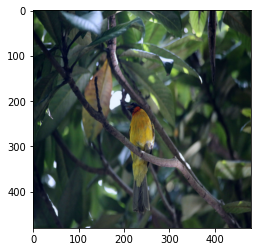

In [8]:
response = requests.get("https://dl.fbaipublicfiles.com/dino/img.png")
img_npy = Image.open(BytesIO(response.content))
img_npy = img_npy.convert('RGB')
plt.imshow(img_npy)

In [9]:
transform = pth_transforms.Compose([
    pth_transforms.ToTensor(),
    pth_transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])
img = transform(img_npy)

# make the image divisible by the patch size
w, h = img.shape[1] - img.shape[1] % patch_size, img.shape[2] - img.shape[2] % patch_size
img = img[:, :w, :h].unsqueeze(0)

w_featmap = img.shape[-2] // patch_size
h_featmap = img.shape[-1] // patch_size

In [10]:
attentions_list = model.get_alllayers_selfattention(img.to(device))

C:\Users\HirosatoAkahoshi\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\functional.py:3454: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
C:\Users\HirosatoAkahoshi\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\functional.py:3502: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn(


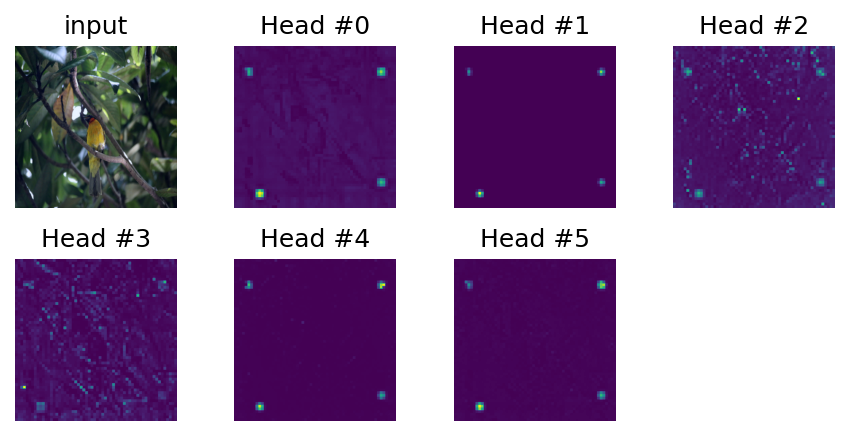

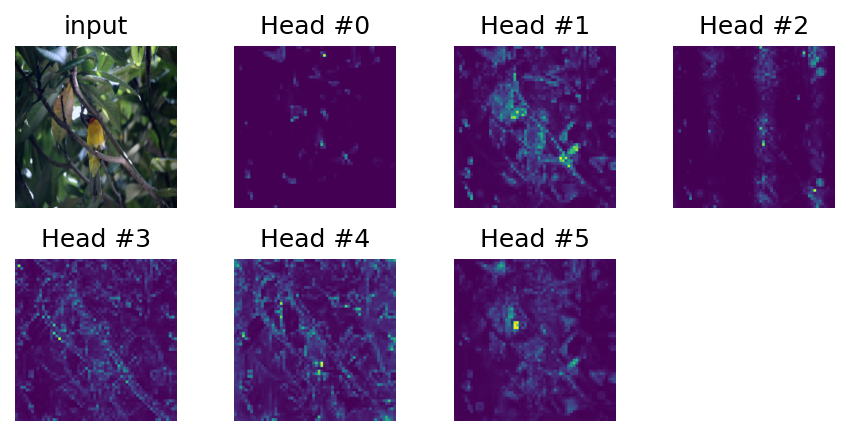

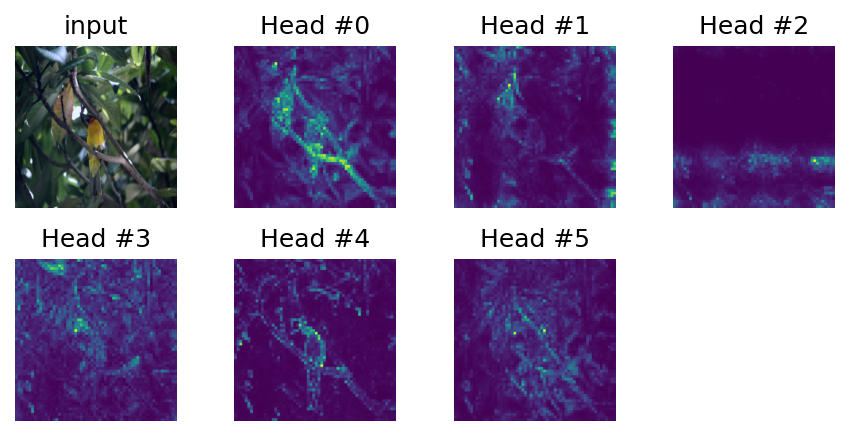

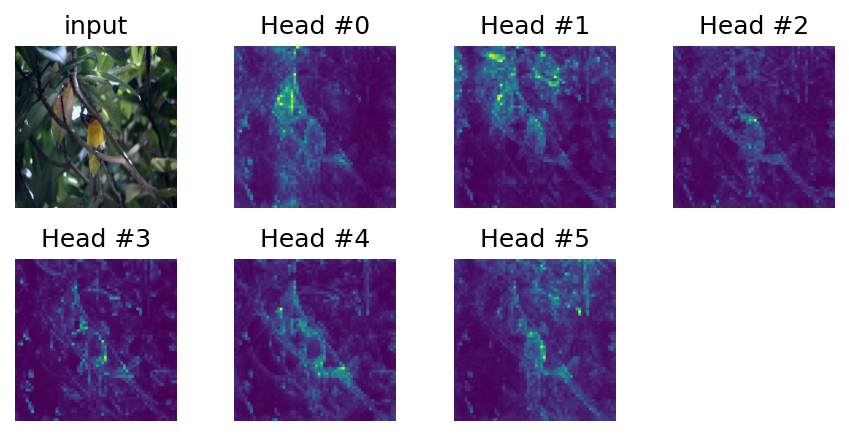

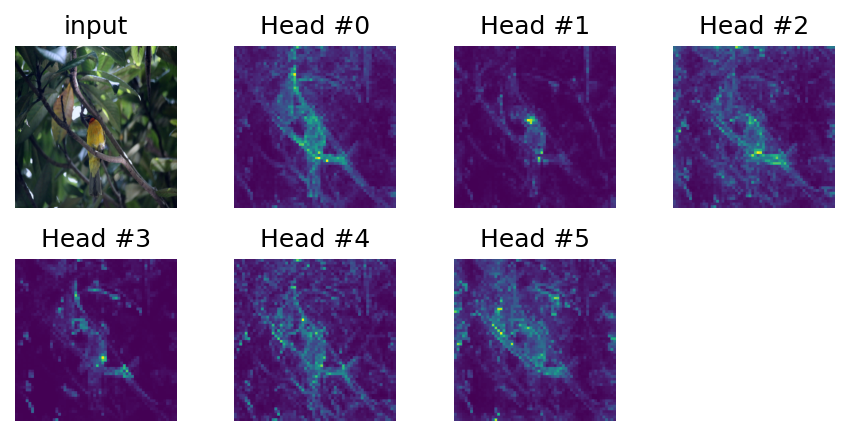

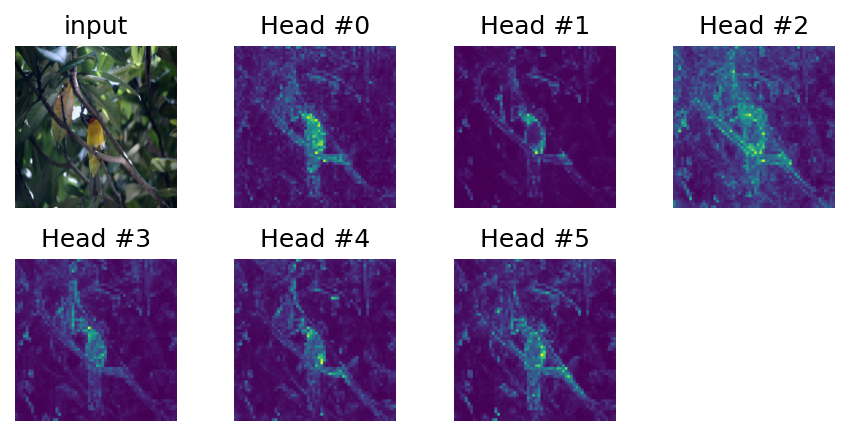

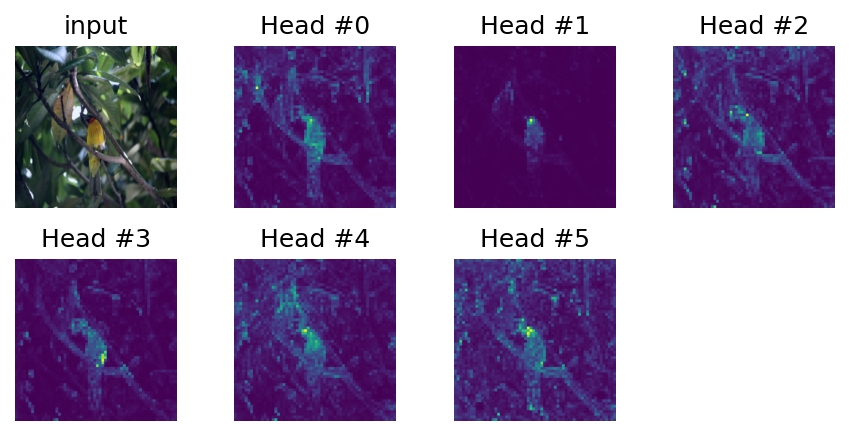

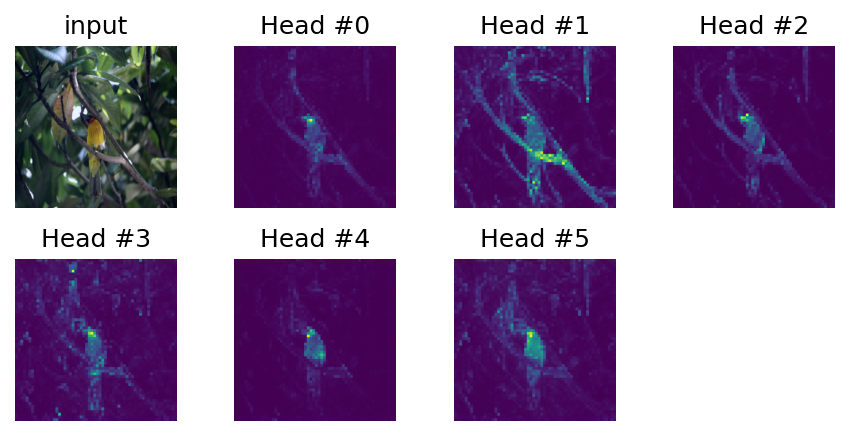

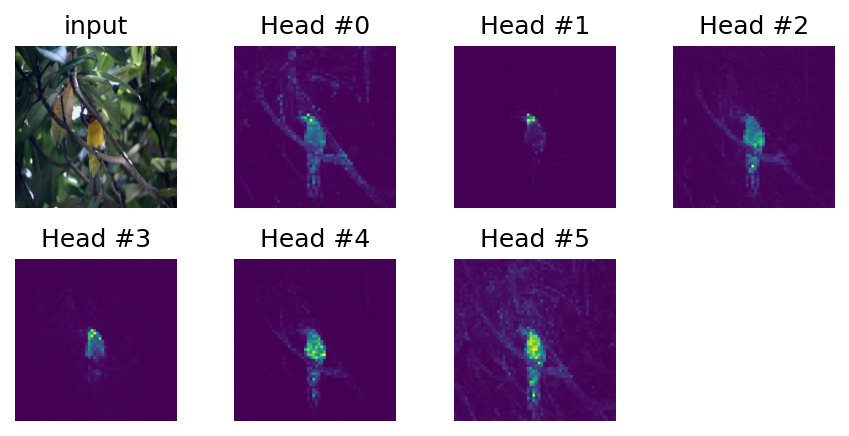

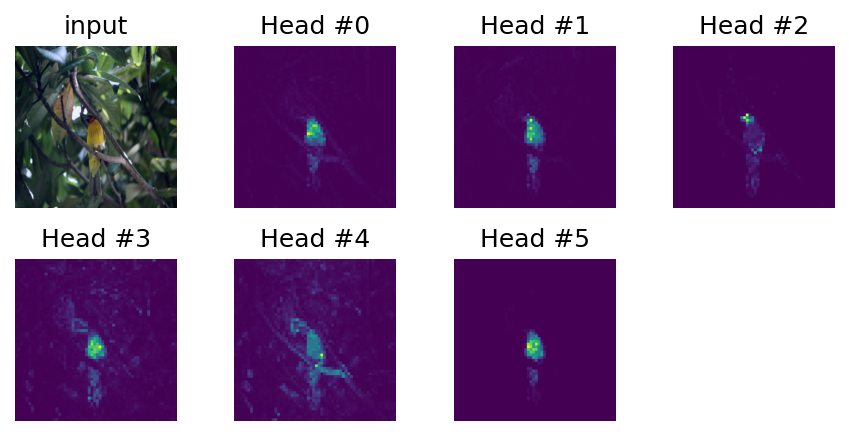

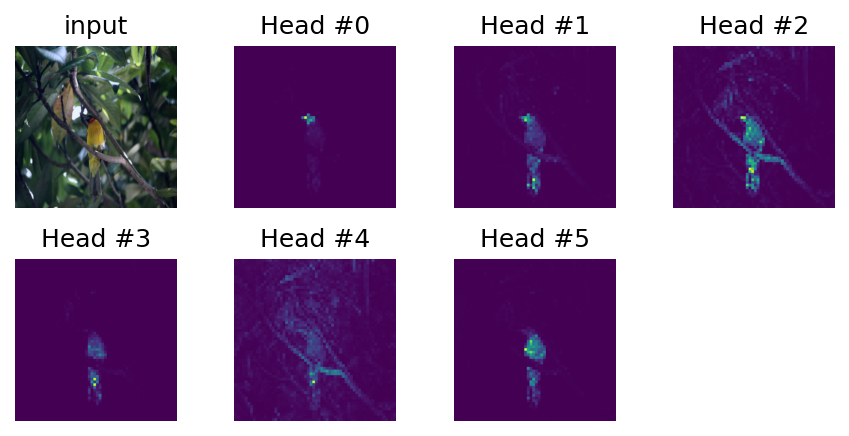

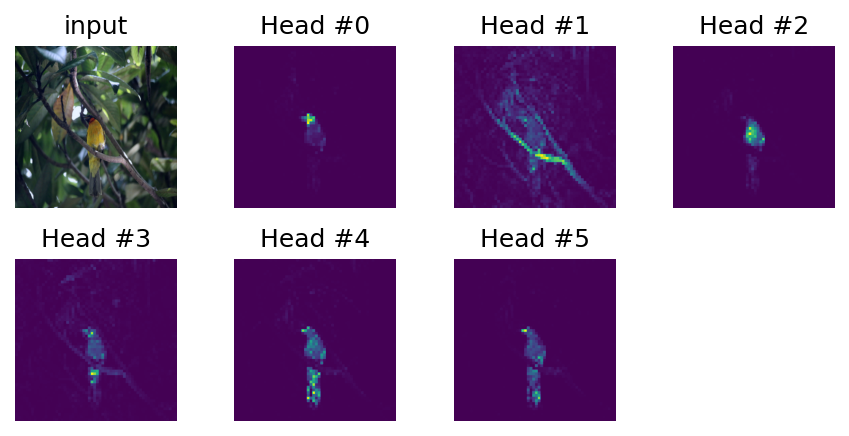

In [11]:
for layer_num, attention in enumerate(attentions_list):
    attentions = attention                                   # [batch_size, num_head, CLS+embed_dim, CLS+embed_dim]
    nh = attentions.shape[1] # number of head

    # we keep only the output patch attention
    attentions = attentions[0, :, 0, 1:].reshape(nh, -1) # [num_head, embed_dim], [CLS] was removed

    # we keep only a certain percentage of the mass
    val, idx = torch.sort(attentions)
    val /= torch.sum(val, dim=1, keepdim=True)
    cumval = torch.cumsum(val, dim=1)
    threshold = 0.6 # We visualize masks obtained by thresholding the self-attention maps to keep xx% of the mass.
    th_attn = cumval > (1 - threshold)
    idx2 = torch.argsort(idx)
    for head in range(nh):
        th_attn[head] = th_attn[head][idx2[head]]
    th_attn = th_attn.reshape(nh, w_featmap, h_featmap).float()
    # interpolate(resize process)
    th_attn = nn.functional.interpolate(th_attn.unsqueeze(0), scale_factor=patch_size, mode="nearest")[0].cpu().numpy()

    attentions = attentions.reshape(nh, w_featmap, h_featmap)
    attentions = nn.functional.interpolate(attentions.unsqueeze(0), scale_factor=patch_size, mode="nearest")[0].cpu().numpy()
    
    plt.figure(figsize=(6, 3), dpi=150)
    plt.subplot(2, 4, 1)
    plt.title("input")
    plt.imshow(img_npy)
    plt.axis("off")
    # visualize self-attention of each head

    for i in range(nh):
        plt.subplot(2, 4, i+2)
        plt.title("Head #"+str(i))
        plt.imshow(attentions[i])
        plt.axis("off")
    plt.tight_layout()

In [11]:
outputs = model.get_last_output(img.to(device))

C:\Users\HirosatoAkahoshi\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\functional.py:3454: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
C:\Users\HirosatoAkahoshi\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\functional.py:3502: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn(


In [12]:
outputs.shape

torch.Size([1, 65536])

In [13]:
outputs = outputs.cpu()

In [14]:
outputs = F.softmax(outputs/0.07, dim=1)

In [15]:
outputs = outputs.numpy().squeeze(0)

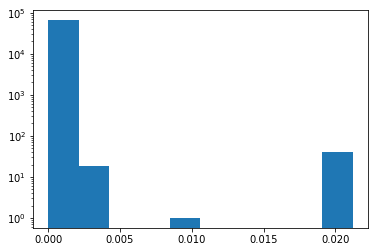

In [16]:
plt.figure()
plt.hist(outputs)
plt.yscale("log")
plt.show()